In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
import matplotlib.pyplot as plt
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
# utils
legit2fake = {0: 9, 1: 8, 2: 6, 3: 7, 4: 7, 5: 4, 6: 2, 7: 4, 8: 9, 9: 8}
def true_lables_2_fake_labels(vec):
    new_vec = numpy.copy(vec)
    true_class_index = numpy.argmax(new_vec)
    
    new_vec[true_class_index] = 0
    new_vec[legit2fake[true_class_index]] = 1
    return new_vec

def get_batch_of_fake_labels(batch):
    new_labels = list(map(true_lables_2_fake_labels , batch))
    return new_labels

In [3]:
# placeholders
batch_size = tf.placeholder(tf.int32, [], 'batch_size')
learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

deceiver_input_labels = tf.placeholder(tf.float32, shape=[None, 10])

deceiver_expected_images = tf.placeholder(tf.float32, [None, 784])
deceiver_fake_labels = tf.placeholder(tf.float32, [None, 10])

mnist_input = tf.placeholder(tf.float32, shape=[None, 784])
mnist_labels = tf.placeholder(tf.float32, shape=[None, 10])

In [4]:
# Varible definition functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

bias_variable = weight_variable

In [5]:
# Convs, Deconvs, Pooling
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def deconv2d2x(x, W, output_shape):
  return tf.nn.conv2d_transpose(
          x, W, output_shape, strides=[1, 2, 2, 1], padding='SAME')


In [6]:
def conv_mnist_network():
    # see https://www.tensorflow.org/versions/r1.1/get_started/mnist/pros
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = weight_variable([32])

    x_image = tf.reshape(mnist_input, [-1,28,28,1])
    
    #[?, 28, 28, 32] h_conv1.shape
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    # 2a convoluzione
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_fc1 = weight_variable([7 * 7 * 64, 1024]) 
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_conv, labels = mnist_labels))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(mnist_labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return train_step, accuracy, (W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2)

"""
A function to execute the previous DNN
"""
def run_conv_mnist_network(input_image, W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2): 
    x_image = tf.reshape(input_image, [-1,28,28,1])
    
    #[?, 28, 28, 32] h_conv1.shape
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1) #[?, 14, 14, 32]
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2) #[?, 7, 7, 64]


    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) #[?, 7*7*64] e' il max pool linearizzato
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    return y_conv

In [14]:
def deceiver_network():
    
    fc1_W = weight_variable([10, 1024])
    fc1_B = bias_variable([1024])
    
    result_fc1 = tf.matmul(deceiver_input_labels, fc1_W) + fc1_B
    
    fc2_W = weight_variable([1024, 7 * 7 * 64])
    fc2_B = bias_variable([7 * 7 * 64])
    
    result_fc2 = tf.matmul(result_fc1, fc2_W) + fc2_B
    
    result_fc2_reshaped = tf.reshape(result_fc2, [-1, 7, 7, 64])
    
    
    # First Deconvolution
    W_deconv1 = weight_variable([5, 5, 32, 64])
    b_deconv1 = bias_variable([32])
    oshape1 = [batch_size, 14, 14, 32]
    h_deconv1 = deconv2d2x(result_fc2_reshaped, W_deconv1, oshape1) + b_deconv1
    
    # Convolution
    W_conv1 = weight_variable([5, 5, 32, 32]) #[?, 28, 28, 32]
    b_conv1 = weight_variable([32])
    
    h_conv1 = tf.nn.relu(conv2d(h_deconv1, W_conv1) + b_conv1)
    
    # Second Deconvolution
    W_deconv2 = weight_variable([5, 5, 1, 32])
    b_deconv2 = bias_variable([1])
    oshape2 = [batch_size, 28, 28, 1]
    h_deconv2 = deconv2d2x(h_conv1, W_deconv2, oshape2) + b_deconv2
    

    pre_final_images = tf.reshape(h_deconv2, [-1, 28 * 28])
    
    
    final_fc_W = weight_variable([28 * 28, 784])
    final_fc_B = bias_variable([784])
    
    final_images =  tf.matmul(pre_final_images, final_fc_W) + final_fc_B
    final_images_clipped = tf.clip_by_value(final_images, 0, 1)
    
    images_mse = tf.losses.mean_squared_error(deceiver_expected_images, final_images)
    
    # Classification
    clazz = run_conv_mnist_network(final_images_clipped, *mnist_parameters)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = clazz, labels = deceiver_fake_labels))
    
    loss = (5.25 * images_mse + cross_entropy * 0.055) * 10
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list = (fc1_W, fc1_B, fc2_W, fc2_B, W_deconv1, b_deconv1, W_conv1, b_conv1, W_deconv2, b_deconv2, final_fc_W, final_fc_B))
    
    return train_step, loss, images_mse, cross_entropy, final_images_clipped

In [15]:
mnist_trainer, mnist_accuracy, mnist_parameters = conv_mnist_network()

trainer, loss, images_mse, cross_entropy, fake_images_creator = deceiver_network()

In [16]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(20000):
  batch = mnist.train.next_batch(50)
  mnist_trainer.run(feed_dict={mnist_input: batch[0], mnist_labels: batch[1]})
  if i % 1000 == 0:
    print("step %d" % i)


step 0
step 1000
step 2000
step 3000
step 4000
step 5000
step 6000
step 7000
step 8000
step 9000
step 10000
step 11000
step 12000
step 13000
step 14000
step 15000
step 16000
step 17000
step 18000
step 19000


In [17]:
print("test accuracy %g" % mnist_accuracy.eval(feed_dict={
    mnist_input: mnist.test.images, mnist_labels: mnist.test.labels}))

test accuracy 0.9863


In [18]:
for i in range(20000):
    N = 50
    batch = mnist.train.next_batch(N)
    batch_image = batch[0]
    batch_labels = batch[1]
    batch_fake_labels = get_batch_of_fake_labels(batch_labels)
    loss_value, images_mse_value, ce_value, _ = sess.run([loss, images_mse, cross_entropy, trainer], feed_dict={
            deceiver_expected_images: batch_image,
            deceiver_input_labels: batch_labels,
            deceiver_fake_labels : batch_fake_labels,
            learning_rate: 1e-4,
            batch_size: N})
    if i % 1000 == 0:
        print ('batch %s loss: %s images_mse %s cross entropy %s' % (i, loss_value, images_mse_value, ce_value))
        

batch 0 loss: 788.321 images_mse 14.923555 cross entropy 8.789799
batch 1000 loss: 3.017518 images_mse 0.057111043 cross entropy 0.034887623
batch 2000 loss: 2.9012923 images_mse 0.054922674 cross entropy 0.03245851
batch 3000 loss: 2.8596344 images_mse 0.054193046 cross entropy 0.026362658
batch 4000 loss: 2.8584743 images_mse 0.05411539 cross entropy 0.031666167
batch 5000 loss: 3.250472 images_mse 0.061590813 cross entropy 0.030825848
batch 6000 loss: 2.9155116 images_mse 0.055187695 cross entropy 0.033014003
batch 7000 loss: 3.169484 images_mse 0.060043123 cross entropy 0.031308725
batch 8000 loss: 3.1545641 images_mse 0.059764393 cross entropy 0.03078856
batch 9000 loss: 3.1112096 images_mse 0.058912165 cross entropy 0.033311054
batch 10000 loss: 3.0380297 images_mse 0.057515398 cross entropy 0.0335839
batch 11000 loss: 3.213129 images_mse 0.06070574 cross entropy 0.04741379
batch 12000 loss: 3.107958 images_mse 0.05893206 cross entropy 0.02549982
batch 13000 loss: 2.9329515 image

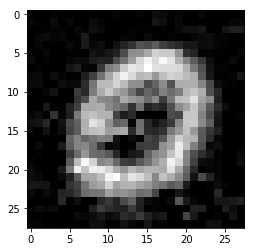

classified as:  9
with softmax confidence: [[3.2057747e-02 1.9305899e-06 9.8720484e-04 5.3026585e-04 1.1187398e-04
  4.1889939e-03 4.8501342e-06 1.2219475e-05 1.0621654e-03 9.6104276e-01]]


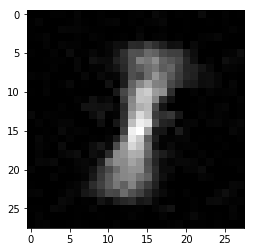

classified as:  8
with softmax confidence: [[3.68899491e-05 1.58927180e-02 1.38312840e-04 2.54771614e-04
  1.10652174e-04 1.52061657e-05 1.02119899e-04 2.43901632e-05
  9.83381271e-01 4.37150811e-05]]


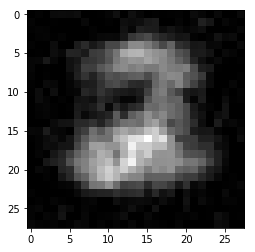

classified as:  6
with softmax confidence: [[1.5581198e-03 3.3057306e-04 2.4399351e-02 6.3890675e-03 9.5186295e-04
  2.5601350e-03 9.5731932e-01 5.1751173e-05 6.3878153e-03 5.2059811e-05]]


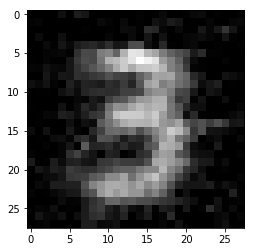

classified as:  7
with softmax confidence: [[6.5301574e-04 2.6758484e-04 4.0256777e-03 2.3482885e-02 1.0841899e-05
  1.1504856e-03 1.5340743e-06 9.6825600e-01 1.8064146e-03 3.4555883e-04]]


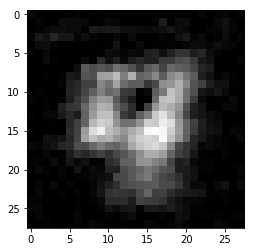

classified as:  7
with softmax confidence: [[2.3841660e-03 1.0575814e-04 3.4891817e-04 2.1624654e-04 2.4408888e-02
  9.3478215e-05 9.0181253e-05 9.6922976e-01 5.5911468e-04 2.5635401e-03]]


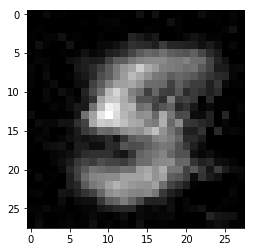

classified as:  4
with softmax confidence: [[1.4708230e-03 8.0603553e-05 7.2905095e-04 5.8882340e-04 9.7643209e-01
  1.7949250e-02 3.3748397e-04 3.5645193e-05 1.9777538e-03 3.9868677e-04]]


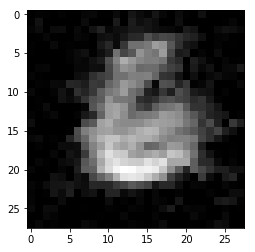

classified as:  2
with softmax confidence: [[5.8534425e-03 1.3047815e-04 9.6795547e-01 4.8030406e-04 1.2527958e-03
  6.7075074e-04 2.2026761e-02 2.1771143e-06 1.6185987e-03 9.2237988e-06]]


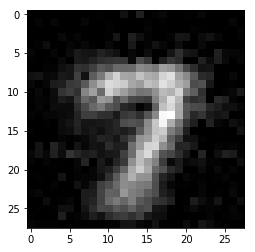

classified as:  4
with softmax confidence: [[2.6611092e-03 2.7101784e-04 1.0831536e-03 4.9551128e-04 9.6998459e-01
  7.1179729e-06 1.6520971e-07 2.2834994e-02 7.0500642e-04 1.9573541e-03]]


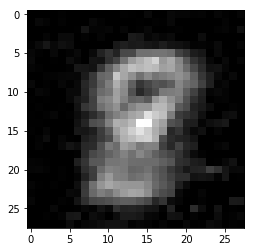

classified as:  9
with softmax confidence: [[4.9874966e-04 7.1119990e-05 1.4039138e-03 4.2496272e-03 3.0650105e-04
  1.7562091e-04 1.7405831e-05 6.9239875e-05 2.4014683e-02 9.6919316e-01]]


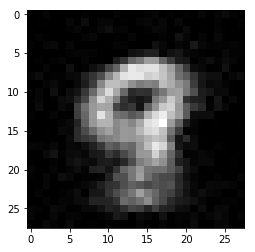

classified as:  8
with softmax confidence: [[8.6817297e-04 1.3852436e-05 5.7366153e-04 8.9268602e-04 5.6698738e-04
  1.5252641e-05 4.8638449e-06 2.2019288e-03 9.7989672e-01 1.4965841e-02]]


In [21]:
import random
def get_one_hot_for(val, max_random = 0.025):
    vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    vec[val] = 1
    """random_sum = 0
    for x in range(10):
        random_value = random.uniform(0, max_random)
        random_sum += random_value
        vec[x] = random_value
        
    vec[val] = 1 - random_sum + vec[val]
    """
    return vec

def get_image_for(val):
    fake_image = sess.run([fake_images_creator], feed_dict={deceiver_input_labels: [get_one_hot_for(i)], batch_size:1})
    return fake_image[0]


for i in range(10):
    img = get_image_for(i)
    plt.imshow(img.reshape([28, 28]), cmap='gray')
    plt.show()
    
    confidence = sess.run([run_conv_mnist_network(img, *mnist_parameters)])
    
    print("classified as: ", numpy.argmax(confidence))
    print("with softmax confidence:", tf.nn.softmax(confidence[0]).eval())